In [390]:
import math
import json
import urllib.request
from urllib.parse import urlencode
import warnings

import pandas as pd
import numpy as np

class bing_maps_api:
    """
    This Class incorporates the most necessary functions to generate new VRP test cases.
    
    Args:
        api_key:    A valid Bing API key (https://www.bingmapsportal.com/Report)
        
    """
    def __init__(self, api_key):
        self.api_key=api_key

    @staticmethod
    def __coordinates_to_str(coordinate_tuple):
        return f"{str(coordinate_tuple[0])},{str(coordinate_tuple[1])}"

    @staticmethod
    def __get_data(url):
        request = urllib.request.Request(url)
        response = urllib.request.urlopen(request)
        return json.loads(response.read())["resourceSets"][0]["resources"][0]
    
    def request_coordinates(self, address_list):
        """
        # TODO
        """
        coordinates = []
        for address in address_list:
            # setup request
            request_dict = {"addressLine":address,
                            "maxResults":1,
                            "key": self.api_key}
            request_append = urlencode(request_dict)
            
            # perform REST API call
            url = f"http://dev.virtualearth.net/REST/v1/Locations?&{request_append}"
            return_data = self.__get_data(url)
        
            if return_data["confidence"] != "High":
                warnings.warn(f"Address confidence for {address} is not high")

            coordinates.append(tuple(return_data["geocodePoints"][0]["coordinates"]))
        return coordinates
        
    
    def request_elevation(self, coordinate_list):
        """
        Get a list of elevation values for a given list of coordinate tuples

        Args:
            coordinate_list:    List of tuples in form [(lat1, long1), (lat1, long2)]

        Returns:
            elevation_list:     List of integers [a1, a2]
        """
        
        batch_size = 50
        number_batches = math.ceil(len(coordinate_list)/ batch_size)
        
        elevations = []
        for x in range(number_batches):
            start_id = x*batch_size
            end_id = min((x+1)*batch_size, len(coordinate_list))
            
            coordinate_string_list = [self.__coordinates_to_str(coordinates) for coordinates in coordinate_list[start_id : end_id]]
            coordinate_string = ",".join(coordinate_string_list)
            
            # perform REST API call
            url = f"http://dev.virtualearth.net/REST/v1/Elevation/List?points={coordinate_string}&key={self.api_key}"
            elevations.extend(self.__get_data(url)["elevations"])
        return elevations
    
    def get_distance_matrix(self, coordinate_list, travel_mode="driving",**kwargs):
        """
        Get the nxn distance matrix for a list of coordinate tuples
        The Bing API supports at max 2500 coordinates at once.

        Args:
            coordinate_list:    List of coordinates. format: [(lat1, long1), (lat2, long2)]
            travel_mode:        Mode that should be used for route finding. Impacts the roads that can be selected
                                Possible: "driving", "walking", "commute"
            **kwargs:           Other optinal parameters.(https://msdn.microsoft.com/en-us/library/mt827298.aspx)

        Returns:
            distance_matrix:    nxn List of lists containing the distance matrix from all origins to all destinations

        """
        # setup request
        batch_size_destinations = 40
        batch_size_origins = 10        
        
        nr_locations = len(coordinate_list)
        distance_matrix = np.zeros((nr_locations,nr_locations))
        
        # request in matches
        batch_iterations_origins = math.ceil(nr_locations/batch_size_origins)
        batch_iterations_destinations = math.ceil(nr_locations/batch_size_destinations)
        for x in range(batch_iterations_origins):
            for y in range(batch_iterations_destinations):
                current_id_origins = x*batch_size_origins
                current_id_destinations = y*batch_size_destinations
                
                id_end_origins = min((x+1)*batch_size_origins, len(coordinate_list))
                id_end_destinations = min((y+1)*batch_size_destinations, len(coordinate_list))
                
                
                coordinate_string_list_origins = [self.__coordinates_to_str(coordinates) for coordinates in coordinate_list[current_id_origins : id_end_origins]]
                coordinate_string_origins = ";".join(coordinate_string_list_origins)    

                coordinate_string_list_destinations = [self.__coordinates_to_str(coordinates) for coordinates in coordinate_list[current_id_destinations : id_end_destinations]]
                coordinate_string_destinations = ";".join(coordinate_string_list_destinations)  
                
                request_dict = {"origins": coordinate_string_origins,
                                "destinations": coordinate_string_destinations,
                               "travelMode": travel_mode,
                               **kwargs,
                               "key": self.api_key}

                request_append = urlencode(request_dict)

                request_append = request_append.replace("%2C", ",")
                request_append = request_append.replace("%3B", ";")

                # perform REST API call
                url =   f"https://dev.virtualearth.net/REST/v1/Routes/DistanceMatrix?{request_append}"

                print("url")
                print(url)
                print("request")
                return_data = self.__get_data(url)

                # do postprocessing
                for row in return_data["results"]:
                    origin_index = row["originIndex"] + current_id_origins
                    dest_index = row["destinationIndex"] + current_id_destinations
                    distance = row["travelDistance"]

                    distance_matrix[origin_index, dest_index] = distance
        return distance_matrix

In [391]:
bing_api_key = "AlP0tP_pFZX72jI-WsCLXTrt7uFKgfuU4AGmPooke2nJub-dWnqXkNUNr3dqPdGM"

# 1) Import List of addresses

# 2) Build cases

In [362]:
n = 200
n_cases = 3

##  2.1) Build time windows

In [311]:
avg_length = 55
min_length = 10
window_length = 120

start = [round(np.random.uniform(0, window_length-min_length)) for x in range(n)]
end = [min(window_length, x + round(np.random.uniform(min_length, avg_length*2+min_length))) for x in start]

In [312]:
time_windows = list(zip(start, end))

# Min length: 10 guaranteed
# Max length: 100
# avg length: 

## 2.2) Build demand

In [363]:
min_demand = 5
max_demand = 30

demand = [[round(np.random.uniform(min_demand, max_demand)) for x in range(n)] for y in range(n_cases)]
service_time = [5 for x in range(n)]

## 2.3) Build geo-coordinates

In [432]:
base_path = "C:\\Users\\manuf\\OneDrive\\Dokumente\\Universitaet\\Masterthesis\\data\\vrpldtt_freytag\\cases"
bing_api = bing_maps_api(bing_api_key)

limits = {"Fukuoka": {"x": (33.5720598, 33.6009464), "y": (130.3803101, 130.4618392)},
         "Madrid": {"x": (40.4075056, 40.4127996) , "y": (-3.6970027, -3.7035559)},
         "Pittsburgh" :{"x": (40.4616091, 40.4709129), "y": (-79.9153374, -79.9659317)},
         "Seattle" : {"x" :(47.537409, 47.563277), "y": (-122.267615, -122.296401)},
         "Sydney" : {"x": (-33.895585, -33.842020), "y": (150.976837, 151.025632)}}

limits = {
         "Sydney" : {"x": (-33.895585, -33.842020), "y": (150.976837, 151.025632)}}

In [433]:
for city in limits:
    x = [np.random.uniform(limits[city]["x"][0], limits[city]["x"][1]) for x in range(n)]
    y = [np.random.uniform(limits[city]["y"][0], limits[city]["y"][1]) for x in range(n)]
    coordinate_list = list(zip(x, y))
    
    distance_matrix = bing_api.get_distance_matrix(coordinate_list)
    elevation_list = bing_api.request_elevation(coordinate_list)
    
    # Build df!
    distance_cols = [x for x in range(n)]
    columns = ["x", "y", "elevation", "demand", "tw a", "tw b", "s"] + distance_cols

    for case_id in range(n_cases):
        df = pd.DataFrame(columns=columns)
        for row_id in range(n):
            row = {}
            row["x"] = x[row_id]
            row["y"] = y[row_id]
            row["elevation"] = elevation_list[row_id]
            row["demand"] = demand[case_id][row_id]
            row["tw a"] = start[row_id]
            row["tw b"] = end[row_id]
            row["s"] = service_time[row_id]
            row.update({dcol: distance_matrix[row_id][dcol] for dcol in distance_cols})
            df = df.append(row, ignore_index=True)

        # Export!
        df.to_csv(f"{city[:2]}{case_id+1}_200.csv")
        df.iloc[:100, :107].to_csv(f"{city[:2]}{case_id+1}_100.csv")
        df.iloc[:50, :57].to_csv(f"{city[:2]}{case_id+1}_50.csv")

url
https://dev.virtualearth.net/REST/v1/Routes/DistanceMatrix?origins=-33.8942186511891,151.004848657999;-33.84897236481048,150.99067631484758;-33.88389288715858,151.00738387766674;-33.857583111034835,150.99714687996442;-33.89224998746615,151.0230482804215;-33.844693642579884,151.0183248731818;-33.89027517548303,150.99252487942158;-33.88558146990619,150.9813266868692;-33.871593515770236,150.98932256846942;-33.850982587778056,151.01306628936888&destinations=-33.8942186511891,151.004848657999;-33.84897236481048,150.99067631484758;-33.88389288715858,151.00738387766674;-33.857583111034835,150.99714687996442;-33.89224998746615,151.0230482804215;-33.844693642579884,151.0183248731818;-33.89027517548303,150.99252487942158;-33.88558146990619,150.9813266868692;-33.871593515770236,150.98932256846942;-33.850982587778056,151.01306628936888;-33.850177246385954,150.99176354274093;-33.84273257281407,150.98319715371852;-33.86127645508422,151.0175326228124;-33.86807222045015,151.0192482397842;-33.85823

url
https://dev.virtualearth.net/REST/v1/Routes/DistanceMatrix?origins=-33.8942186511891,151.004848657999;-33.84897236481048,150.99067631484758;-33.88389288715858,151.00738387766674;-33.857583111034835,150.99714687996442;-33.89224998746615,151.0230482804215;-33.844693642579884,151.0183248731818;-33.89027517548303,150.99252487942158;-33.88558146990619,150.9813266868692;-33.871593515770236,150.98932256846942;-33.850982587778056,151.01306628936888&destinations=-33.85558029272896,150.99576634842558;-33.870745619728496,151.0218680789618;-33.867906914452846,151.0100946299166;-33.895498652006914,151.00092300178338;-33.89415326576772,151.0107022106874;-33.87205124663062,151.02266993585113;-33.84553516227298,151.0044725215485;-33.84979213503755,151.02077997932682;-33.85361920658726,151.0030290922605;-33.88271496778979,151.01086854545952;-33.848486070366384,150.98406652621625;-33.852578976279545,150.98609790509533;-33.856326532251536,151.00310270185247;-33.8682282222287,150.9771264372624;-33.858

url
https://dev.virtualearth.net/REST/v1/Routes/DistanceMatrix?origins=-33.850177246385954,150.99176354274093;-33.84273257281407,150.98319715371852;-33.86127645508422,151.0175326228124;-33.86807222045015,151.0192482397842;-33.858231089452076,151.01963170758276;-33.89180812457239,150.99429871775754;-33.85690007806546,150.99917761698907;-33.880845313422284,151.01605091667489;-33.85534131166211,150.98334406934373;-33.87475971427254,151.02140758971322&destinations=-33.86530368569173,150.9871983032814;-33.84426052926582,151.0091427296265;-33.85165007912437,151.00947156636386;-33.88741987878443,150.99573769421693;-33.87199472967892,151.0000566081595;-33.85830257937656,151.00404525081632;-33.87769307804242,150.9956338671488;-33.85640505727011,150.97899404185674;-33.850457583351506,150.9777295297494;-33.8512293471651,150.99339038247905;-33.86928169709272,150.98437411988232;-33.868424959555306,150.99103070261543;-33.8717897787441,150.99588843592625;-33.85959757298661,151.02560101270436;-33.8810

url
https://dev.virtualearth.net/REST/v1/Routes/DistanceMatrix?origins=-33.88889230653271,150.99820616300138;-33.8808993321778,150.9982466454224;-33.88696853463848,151.00588392240655;-33.8837217102389,151.0079929078837;-33.87048496932567,150.9825913625018;-33.85701699370772,151.0254509079823;-33.85917549396811,150.98307135089968;-33.87910665148852,151.00329603104947;-33.891096082054844,150.9814483202968;-33.867881326143156,150.98631263723084&destinations=-33.882322233711065,151.0221669718343;-33.86342395413299,150.98154383515924;-33.874282635470614,151.01829772184476;-33.8931102461039,151.01024768325036;-33.858569834490424,151.00289681150565;-33.84277420833507,151.00642871941497;-33.888919049772525,151.0231808979589;-33.84505104752307,151.01536922850173;-33.86788955783684,151.0225496156295;-33.86782572987782,150.98496213154857;-33.877106152346116,150.9794244522277;-33.85267487906302,150.983798664742;-33.847089909836775,151.00686943737372;-33.85951697152684,150.97755982465134;-33.842721

url
https://dev.virtualearth.net/REST/v1/Routes/DistanceMatrix?origins=-33.846305091394285,150.97740731134488;-33.858817033948824,150.9997241682437;-33.88534765532533,150.98904317299778;-33.86578534246037,151.02346204179145;-33.8825546095469,151.00406039311204;-33.88015740389936,151.01665256613666;-33.895284022771996,151.00920633412005;-33.863211230805135,150.98837665756017;-33.847574653058864,150.98986577444515;-33.84472591258291,150.99872568817935&destinations=-33.85178958950518,151.01400075684919;-33.868473997489694,150.99078108109285;-33.88378920851273,151.01281653460345;-33.851771462277455,151.0130882846544;-33.84621565491578,150.98872536388674;-33.874102585454025,151.0223131892019;-33.88025166488615,151.00191814308403;-33.84962770327985,151.0145614240879;-33.88932035023664,150.98371680373342;-33.864053082342686,150.9946569800758;-33.87482782039418,150.98757723820125;-33.892790891929565,151.00152848806033;-33.89447737479184,151.02189548362784;-33.89328523434345,150.99158039682342;

url
https://dev.virtualearth.net/REST/v1/Routes/DistanceMatrix?origins=-33.85178958950518,151.01400075684919;-33.868473997489694,150.99078108109285;-33.88378920851273,151.01281653460345;-33.851771462277455,151.0130882846544;-33.84621565491578,150.98872536388674;-33.874102585454025,151.0223131892019;-33.88025166488615,151.00191814308403;-33.84962770327985,151.0145614240879;-33.88932035023664,150.98371680373342;-33.864053082342686,150.9946569800758&destinations=-33.8942186511891,151.004848657999;-33.84897236481048,150.99067631484758;-33.88389288715858,151.00738387766674;-33.857583111034835,150.99714687996442;-33.89224998746615,151.0230482804215;-33.844693642579884,151.0183248731818;-33.89027517548303,150.99252487942158;-33.88558146990619,150.9813266868692;-33.871593515770236,150.98932256846942;-33.850982587778056,151.01306628936888;-33.850177246385954,150.99176354274093;-33.84273257281407,150.98319715371852;-33.86127645508422,151.0175326228124;-33.86807222045015,151.0192482397842;-33.858

url
https://dev.virtualearth.net/REST/v1/Routes/DistanceMatrix?origins=-33.85178958950518,151.01400075684919;-33.868473997489694,150.99078108109285;-33.88378920851273,151.01281653460345;-33.851771462277455,151.0130882846544;-33.84621565491578,150.98872536388674;-33.874102585454025,151.0223131892019;-33.88025166488615,151.00191814308403;-33.84962770327985,151.0145614240879;-33.88932035023664,150.98371680373342;-33.864053082342686,150.9946569800758&destinations=-33.85558029272896,150.99576634842558;-33.870745619728496,151.0218680789618;-33.867906914452846,151.0100946299166;-33.895498652006914,151.00092300178338;-33.89415326576772,151.0107022106874;-33.87205124663062,151.02266993585113;-33.84553516227298,151.0044725215485;-33.84979213503755,151.02077997932682;-33.85361920658726,151.0030290922605;-33.88271496778979,151.01086854545952;-33.848486070366384,150.98406652621625;-33.852578976279545,150.98609790509533;-33.856326532251536,151.00310270185247;-33.8682282222287,150.9771264372624;-33.8

url
https://dev.virtualearth.net/REST/v1/Routes/DistanceMatrix?origins=-33.87482782039418,150.98757723820125;-33.892790891929565,151.00152848806033;-33.89447737479184,151.02189548362784;-33.89328523434345,150.99158039682342;-33.85379386335157,151.01159540035047;-33.88107528001658,151.01197525497892;-33.859710463957065,151.0212402750858;-33.845327097682656,150.99371218844496;-33.8818768865166,150.9972224257094;-33.87372389349828,151.00136404042868&destinations=-33.86530368569173,150.9871983032814;-33.84426052926582,151.0091427296265;-33.85165007912437,151.00947156636386;-33.88741987878443,150.99573769421693;-33.87199472967892,151.0000566081595;-33.85830257937656,151.00404525081632;-33.87769307804242,150.9956338671488;-33.85640505727011,150.97899404185674;-33.850457583351506,150.9777295297494;-33.8512293471651,150.99339038247905;-33.86928169709272,150.98437411988232;-33.868424959555306,150.99103070261543;-33.8717897787441,150.99588843592625;-33.85959757298661,151.02560101270436;-33.88103

url
https://dev.virtualearth.net/REST/v1/Routes/DistanceMatrix?origins=-33.884076193836826,150.9839445482256;-33.88755912653179,151.0084267744132;-33.84624833830804,151.0091796281229;-33.879144079898246,151.0256206945068;-33.8703529990002,151.004482980019;-33.84684617377929,150.99536502533607;-33.877960184101994,151.02388047078617;-33.85421510796041,151.005341707381;-33.860462921843684,150.98588868237113;-33.858038367284436,150.9890197293492&destinations=-33.882322233711065,151.0221669718343;-33.86342395413299,150.98154383515924;-33.874282635470614,151.01829772184476;-33.8931102461039,151.01024768325036;-33.858569834490424,151.00289681150565;-33.84277420833507,151.00642871941497;-33.888919049772525,151.0231808979589;-33.84505104752307,151.01536922850173;-33.86788955783684,151.0225496156295;-33.86782572987782,150.98496213154857;-33.877106152346116,150.9794244522277;-33.85267487906302,150.983798664742;-33.847089909836775,151.00686943737372;-33.85951697152684,150.97755982465134;-33.842721

url
https://dev.virtualearth.net/REST/v1/Routes/DistanceMatrix?origins=-33.88233594652262,150.98651129746142;-33.84892880389704,150.99812158851384;-33.86450194433613,151.01483112296793;-33.863728434080606,150.9778229107642;-33.87325341725401,151.0028643690842;-33.846448252864235,150.9921671698289;-33.884943596991995,150.97943225870068;-33.89293253948594,150.98794477267123;-33.87831137238401,150.98122466713278;-33.8446350890501,150.9988020538052&destinations=-33.85178958950518,151.01400075684919;-33.868473997489694,150.99078108109285;-33.88378920851273,151.01281653460345;-33.851771462277455,151.0130882846544;-33.84621565491578,150.98872536388674;-33.874102585454025,151.0223131892019;-33.88025166488615,151.00191814308403;-33.84962770327985,151.0145614240879;-33.88932035023664,150.98371680373342;-33.864053082342686,150.9946569800758;-33.87482782039418,150.98757723820125;-33.892790891929565,151.00152848806033;-33.89447737479184,151.02189548362784;-33.89328523434345,150.99158039682342;-33.8

url
https://dev.virtualearth.net/REST/v1/Routes/DistanceMatrix?origins=-33.882322233711065,151.0221669718343;-33.86342395413299,150.98154383515924;-33.874282635470614,151.01829772184476;-33.8931102461039,151.01024768325036;-33.858569834490424,151.00289681150565;-33.84277420833507,151.00642871941497;-33.888919049772525,151.0231808979589;-33.84505104752307,151.01536922850173;-33.86788955783684,151.0225496156295;-33.86782572987782,150.98496213154857&destinations=-33.8942186511891,151.004848657999;-33.84897236481048,150.99067631484758;-33.88389288715858,151.00738387766674;-33.857583111034835,150.99714687996442;-33.89224998746615,151.0230482804215;-33.844693642579884,151.0183248731818;-33.89027517548303,150.99252487942158;-33.88558146990619,150.9813266868692;-33.871593515770236,150.98932256846942;-33.850982587778056,151.01306628936888;-33.850177246385954,150.99176354274093;-33.84273257281407,150.98319715371852;-33.86127645508422,151.0175326228124;-33.86807222045015,151.0192482397842;-33.858

url
https://dev.virtualearth.net/REST/v1/Routes/DistanceMatrix?origins=-33.882322233711065,151.0221669718343;-33.86342395413299,150.98154383515924;-33.874282635470614,151.01829772184476;-33.8931102461039,151.01024768325036;-33.858569834490424,151.00289681150565;-33.84277420833507,151.00642871941497;-33.888919049772525,151.0231808979589;-33.84505104752307,151.01536922850173;-33.86788955783684,151.0225496156295;-33.86782572987782,150.98496213154857&destinations=-33.85558029272896,150.99576634842558;-33.870745619728496,151.0218680789618;-33.867906914452846,151.0100946299166;-33.895498652006914,151.00092300178338;-33.89415326576772,151.0107022106874;-33.87205124663062,151.02266993585113;-33.84553516227298,151.0044725215485;-33.84979213503755,151.02077997932682;-33.85361920658726,151.0030290922605;-33.88271496778979,151.01086854545952;-33.848486070366384,150.98406652621625;-33.852578976279545,150.98609790509533;-33.856326532251536,151.00310270185247;-33.8682282222287,150.9771264372624;-33.8

url
https://dev.virtualearth.net/REST/v1/Routes/DistanceMatrix?origins=-33.877106152346116,150.9794244522277;-33.85267487906302,150.983798664742;-33.847089909836775,151.00686943737372;-33.85951697152684,150.97755982465134;-33.84272127210372,150.9891156382818;-33.89195764062507,150.98127781010612;-33.8667618818474,151.01112243372197;-33.84501106375654,151.00211429185794;-33.88609040108869,151.0062888681957;-33.88779425899078,150.9812700177175&destinations=-33.86530368569173,150.9871983032814;-33.84426052926582,151.0091427296265;-33.85165007912437,151.00947156636386;-33.88741987878443,150.99573769421693;-33.87199472967892,151.0000566081595;-33.85830257937656,151.00404525081632;-33.87769307804242,150.9956338671488;-33.85640505727011,150.97899404185674;-33.850457583351506,150.9777295297494;-33.8512293471651,150.99339038247905;-33.86928169709272,150.98437411988232;-33.868424959555306,150.99103070261543;-33.8717897787441,150.99588843592625;-33.85959757298661,151.02560101270436;-33.8810367618

url
https://dev.virtualearth.net/REST/v1/Routes/DistanceMatrix?origins=-33.876786837840534,151.0009359916686;-33.87244713311789,150.97711705099235;-33.8639514133823,151.00209277577315;-33.87374911537768,151.01079882544477;-33.89364825724094,150.99432116772843;-33.88647084824649,151.00030307236267;-33.868794745608774,150.99624815333277;-33.87595739159084,151.01278169194765;-33.88220770783076,151.02214454056968;-33.86602035610633,150.99998428026302&destinations=-33.882322233711065,151.0221669718343;-33.86342395413299,150.98154383515924;-33.874282635470614,151.01829772184476;-33.8931102461039,151.01024768325036;-33.858569834490424,151.00289681150565;-33.84277420833507,151.00642871941497;-33.888919049772525,151.0231808979589;-33.84505104752307,151.01536922850173;-33.86788955783684,151.0225496156295;-33.86782572987782,150.98496213154857;-33.877106152346116,150.9794244522277;-33.85267487906302,150.983798664742;-33.847089909836775,151.00686943737372;-33.85951697152684,150.97755982465134;-33.8

url
https://dev.virtualearth.net/REST/v1/Routes/DistanceMatrix?origins=-33.875918735190176,151.0153388360301;-33.85983959782674,151.01556516505866;-33.86795521598825,151.00735767490926;-33.871813033104736,150.99500106144907;-33.87273194634697,151.01841726885314;-33.84558508850518,151.00926046068543;-33.86314127052904,150.9926273655967;-33.88556734240353,150.98719873400856;-33.88931084077636,150.99097060747818;-33.871007248252546,151.00814200333778&destinations=-33.85178958950518,151.01400075684919;-33.868473997489694,150.99078108109285;-33.88378920851273,151.01281653460345;-33.851771462277455,151.0130882846544;-33.84621565491578,150.98872536388674;-33.874102585454025,151.0223131892019;-33.88025166488615,151.00191814308403;-33.84962770327985,151.0145614240879;-33.88932035023664,150.98371680373342;-33.864053082342686,150.9946569800758;-33.87482782039418,150.98757723820125;-33.892790891929565,151.00152848806033;-33.89447737479184,151.02189548362784;-33.89328523434345,150.99158039682342;-3

url
https://dev.virtualearth.net/REST/v1/Routes/DistanceMatrix?origins=-33.86530368569173,150.9871983032814;-33.84426052926582,151.0091427296265;-33.85165007912437,151.00947156636386;-33.88741987878443,150.99573769421693;-33.87199472967892,151.0000566081595;-33.85830257937656,151.00404525081632;-33.87769307804242,150.9956338671488;-33.85640505727011,150.97899404185674;-33.850457583351506,150.9777295297494;-33.8512293471651,150.99339038247905&destinations=-33.8942186511891,151.004848657999;-33.84897236481048,150.99067631484758;-33.88389288715858,151.00738387766674;-33.857583111034835,150.99714687996442;-33.89224998746615,151.0230482804215;-33.844693642579884,151.0183248731818;-33.89027517548303,150.99252487942158;-33.88558146990619,150.9813266868692;-33.871593515770236,150.98932256846942;-33.850982587778056,151.01306628936888;-33.850177246385954,150.99176354274093;-33.84273257281407,150.98319715371852;-33.86127645508422,151.0175326228124;-33.86807222045015,151.0192482397842;-33.85823108

url
https://dev.virtualearth.net/REST/v1/Routes/DistanceMatrix?origins=-33.86530368569173,150.9871983032814;-33.84426052926582,151.0091427296265;-33.85165007912437,151.00947156636386;-33.88741987878443,150.99573769421693;-33.87199472967892,151.0000566081595;-33.85830257937656,151.00404525081632;-33.87769307804242,150.9956338671488;-33.85640505727011,150.97899404185674;-33.850457583351506,150.9777295297494;-33.8512293471651,150.99339038247905&destinations=-33.85558029272896,150.99576634842558;-33.870745619728496,151.0218680789618;-33.867906914452846,151.0100946299166;-33.895498652006914,151.00092300178338;-33.89415326576772,151.0107022106874;-33.87205124663062,151.02266993585113;-33.84553516227298,151.0044725215485;-33.84979213503755,151.02077997932682;-33.85361920658726,151.0030290922605;-33.88271496778979,151.01086854545952;-33.848486070366384,150.98406652621625;-33.852578976279545,150.98609790509533;-33.856326532251536,151.00310270185247;-33.8682282222287,150.9771264372624;-33.858054

url
https://dev.virtualearth.net/REST/v1/Routes/DistanceMatrix?origins=-33.86928169709272,150.98437411988232;-33.868424959555306,150.99103070261543;-33.8717897787441,150.99588843592625;-33.85959757298661,151.02560101270436;-33.881036761868025,151.0193965756125;-33.85764477750246,150.98192365000975;-33.8673527931887,151.01535987673702;-33.85510347975,151.00719608964266;-33.84999168322342,151.0215100379836;-33.89025059919703,150.98454383750152&destinations=-33.86530368569173,150.9871983032814;-33.84426052926582,151.0091427296265;-33.85165007912437,151.00947156636386;-33.88741987878443,150.99573769421693;-33.87199472967892,151.0000566081595;-33.85830257937656,151.00404525081632;-33.87769307804242,150.9956338671488;-33.85640505727011,150.97899404185674;-33.850457583351506,150.9777295297494;-33.8512293471651,150.99339038247905;-33.86928169709272,150.98437411988232;-33.868424959555306,150.99103070261543;-33.8717897787441,150.99588843592625;-33.85959757298661,151.02560101270436;-33.8810367618

url
https://dev.virtualearth.net/REST/v1/Routes/DistanceMatrix?origins=-33.859905913043086,151.01541470538825;-33.859813640347404,151.01680417286047;-33.88497657882502,151.0193443672429;-33.87836193957504,151.01819913255028;-33.89207413629057,151.0249517252518;-33.870815262989936,150.98903522779054;-33.85512733023515,150.99367889418426;-33.890360446249,150.9827349259355;-33.87603307604178,151.02218940909003;-33.88624561991122,151.00574641194288&destinations=-33.882322233711065,151.0221669718343;-33.86342395413299,150.98154383515924;-33.874282635470614,151.01829772184476;-33.8931102461039,151.01024768325036;-33.858569834490424,151.00289681150565;-33.84277420833507,151.00642871941497;-33.888919049772525,151.0231808979589;-33.84505104752307,151.01536922850173;-33.86788955783684,151.0225496156295;-33.86782572987782,150.98496213154857;-33.877106152346116,150.9794244522277;-33.85267487906302,150.983798664742;-33.847089909836775,151.00686943737372;-33.85951697152684,150.97755982465134;-33.842

url
https://dev.virtualearth.net/REST/v1/Routes/DistanceMatrix?origins=-33.88463871627981,151.02223704355094;-33.856950776921884,150.97773538349486;-33.87098670409478,150.97707010642657;-33.85946729714876,150.98892607216737;-33.84611944691735,151.02070777369826;-33.8531327981582,150.98760034293878;-33.87908756644769,151.00234661406617;-33.88253153453093,150.99246884979513;-33.852145607254336,150.98718068241598;-33.87835895277986,150.9977865217756&destinations=-33.85178958950518,151.01400075684919;-33.868473997489694,150.99078108109285;-33.88378920851273,151.01281653460345;-33.851771462277455,151.0130882846544;-33.84621565491578,150.98872536388674;-33.874102585454025,151.0223131892019;-33.88025166488615,151.00191814308403;-33.84962770327985,151.0145614240879;-33.88932035023664,150.98371680373342;-33.864053082342686,150.9946569800758;-33.87482782039418,150.98757723820125;-33.892790891929565,151.00152848806033;-33.89447737479184,151.02189548362784;-33.89328523434345,150.99158039682342;-33

url
https://dev.virtualearth.net/REST/v1/Routes/DistanceMatrix?origins=-33.85558029272896,150.99576634842558;-33.870745619728496,151.0218680789618;-33.867906914452846,151.0100946299166;-33.895498652006914,151.00092300178338;-33.89415326576772,151.0107022106874;-33.87205124663062,151.02266993585113;-33.84553516227298,151.0044725215485;-33.84979213503755,151.02077997932682;-33.85361920658726,151.0030290922605;-33.88271496778979,151.01086854545952&destinations=-33.8942186511891,151.004848657999;-33.84897236481048,150.99067631484758;-33.88389288715858,151.00738387766674;-33.857583111034835,150.99714687996442;-33.89224998746615,151.0230482804215;-33.844693642579884,151.0183248731818;-33.89027517548303,150.99252487942158;-33.88558146990619,150.9813266868692;-33.871593515770236,150.98932256846942;-33.850982587778056,151.01306628936888;-33.850177246385954,150.99176354274093;-33.84273257281407,150.98319715371852;-33.86127645508422,151.0175326228124;-33.86807222045015,151.0192482397842;-33.85823

url
https://dev.virtualearth.net/REST/v1/Routes/DistanceMatrix?origins=-33.85558029272896,150.99576634842558;-33.870745619728496,151.0218680789618;-33.867906914452846,151.0100946299166;-33.895498652006914,151.00092300178338;-33.89415326576772,151.0107022106874;-33.87205124663062,151.02266993585113;-33.84553516227298,151.0044725215485;-33.84979213503755,151.02077997932682;-33.85361920658726,151.0030290922605;-33.88271496778979,151.01086854545952&destinations=-33.85558029272896,150.99576634842558;-33.870745619728496,151.0218680789618;-33.867906914452846,151.0100946299166;-33.895498652006914,151.00092300178338;-33.89415326576772,151.0107022106874;-33.87205124663062,151.02266993585113;-33.84553516227298,151.0044725215485;-33.84979213503755,151.02077997932682;-33.85361920658726,151.0030290922605;-33.88271496778979,151.01086854545952;-33.848486070366384,150.98406652621625;-33.852578976279545,150.98609790509533;-33.856326532251536,151.00310270185247;-33.8682282222287,150.9771264372624;-33.858

url
https://dev.virtualearth.net/REST/v1/Routes/DistanceMatrix?origins=-33.848486070366384,150.98406652621625;-33.852578976279545,150.98609790509533;-33.856326532251536,151.00310270185247;-33.8682282222287,150.9771264372624;-33.85805431059057,151.00119258092164;-33.87556524638866,151.00005143883516;-33.84689282736665,151.0152379772703;-33.84920865760255,151.0066534126118;-33.852991750914995,151.0227323394125;-33.87931146142408,151.01895563739035&destinations=-33.86530368569173,150.9871983032814;-33.84426052926582,151.0091427296265;-33.85165007912437,151.00947156636386;-33.88741987878443,150.99573769421693;-33.87199472967892,151.0000566081595;-33.85830257937656,151.00404525081632;-33.87769307804242,150.9956338671488;-33.85640505727011,150.97899404185674;-33.850457583351506,150.9777295297494;-33.8512293471651,150.99339038247905;-33.86928169709272,150.98437411988232;-33.868424959555306,150.99103070261543;-33.8717897787441,150.99588843592625;-33.85959757298661,151.02560101270436;-33.881036

url
https://dev.virtualearth.net/REST/v1/Routes/DistanceMatrix?origins=-33.86843641832057,151.01564277415497;-33.869311535358875,150.98118206841744;-33.85632656501987,150.98199719556905;-33.86792115604755,150.97854269796343;-33.85079049932682,150.98904771874618;-33.85520022382261,151.01596700006033;-33.88562017335604,150.97724328946865;-33.8581822249089,151.01930819326176;-33.89554474587924,150.9894376732206;-33.85233310712363,150.99783021150577&destinations=-33.882322233711065,151.0221669718343;-33.86342395413299,150.98154383515924;-33.874282635470614,151.01829772184476;-33.8931102461039,151.01024768325036;-33.858569834490424,151.00289681150565;-33.84277420833507,151.00642871941497;-33.888919049772525,151.0231808979589;-33.84505104752307,151.01536922850173;-33.86788955783684,151.0225496156295;-33.86782572987782,150.98496213154857;-33.877106152346116,150.9794244522277;-33.85267487906302,150.983798664742;-33.847089909836775,151.00686943737372;-33.85951697152684,150.97755982465134;-33.84

url
https://dev.virtualearth.net/REST/v1/Routes/DistanceMatrix?origins=-33.87747611037225,151.02427903785414;-33.866038176234376,150.9960758103657;-33.84667584723563,150.9878852137795;-33.86845022335948,150.98405573808878;-33.89129184556822,151.0016902020331;-33.851602969835234,151.00626805536837;-33.88519112702227,151.0028390493428;-33.8696654953909,151.00497130069542;-33.887365604874645,150.98287285036852;-33.86747737248888,151.025323769209&destinations=-33.85178958950518,151.01400075684919;-33.868473997489694,150.99078108109285;-33.88378920851273,151.01281653460345;-33.851771462277455,151.0130882846544;-33.84621565491578,150.98872536388674;-33.874102585454025,151.0223131892019;-33.88025166488615,151.00191814308403;-33.84962770327985,151.0145614240879;-33.88932035023664,150.98371680373342;-33.864053082342686,150.9946569800758;-33.87482782039418,150.98757723820125;-33.892790891929565,151.00152848806033;-33.89447737479184,151.02189548362784;-33.89328523434345,150.99158039682342;-33.853

In [416]:
max([max(df.iloc[:, 7:].values[x]) for x in range(len(df))])

6.546

In [399]:
df[["x","y"]].plot()

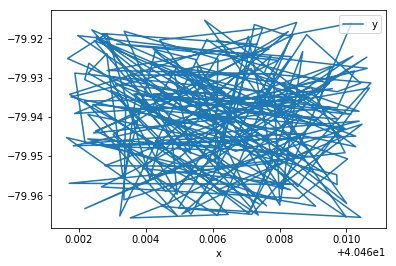

In [401]:
df.plot(x="x", y="y")